# Workforce Lantern

## Import necessary libraries

In [1]:
import pandas as pd
from data.data_functions import *
from simulation.simulation_models import *
from optimization.optimization import *
import warnings

warnings.filterwarnings("ignore")

## Create necessary datasets

### Historical Data

In [2]:
dfs_dict = read_folder_to_dfs("./data/timesdata")
fin_data_hourly = create_hourly_obt(dfs_dict)
fin_data_hourly["skift_type"] = fin_data_hourly.apply(add_shift_type, axis=1)
fin_data_hourly.head(10)

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,skift_type
0,2020,January,1,Wednesday,2020-01-01 00:00:00,0,medisinsk,0,0.0,0.0,natt
1,2020,January,1,Wednesday,2020-01-01 00:00:00,0,kirurgisk,0,1.0,0.0,natt
2,2020,January,1,Wednesday,2020-01-01 01:00:00,1,medisinsk,0,1.0,0.0,natt
3,2020,January,1,Wednesday,2020-01-01 01:00:00,1,kirurgisk,0,1.0,0.0,natt
4,2020,January,1,Wednesday,2020-01-01 02:00:00,2,medisinsk,0,1.0,0.0,natt
5,2020,January,1,Wednesday,2020-01-01 02:00:00,2,kirurgisk,0,0.0,0.0,natt
6,2020,January,1,Wednesday,2020-01-01 03:00:00,3,kirurgisk,0,0.0,0.0,natt
7,2020,January,1,Wednesday,2020-01-01 03:00:00,3,medisinsk,0,0.0,0.0,natt
8,2020,January,1,Wednesday,2020-01-01 04:00:00,4,medisinsk,0,1.0,0.0,natt
9,2020,January,1,Wednesday,2020-01-01 04:00:00,4,kirurgisk,0,0.0,0.0,natt


## Prognostiseringsmodellen

### Predicted Future Demand

In [3]:
fin_data_hourly_med = fin_data_hourly[fin_data_hourly["post"]=="medisinsk"]
fin_data_hourly_kir = fin_data_hourly[fin_data_hourly["post"]=="kirurgisk"]

fin_data_hourly_med["Belegg"] = fin_data_hourly_med.apply(calculate_patients, axis=1)
fin_data_hourly_kir["Belegg"] = fin_data_hourly_kir.apply(calculate_patients, axis=1)

next_year_med = create_forecast_hourly(fin_data_hourly_med, "medisinsk")
next_year_kir = create_forecast_hourly(fin_data_hourly_kir, "kirurgisk")

next_year = pd.concat([next_year_med, next_year_kir], axis=0).sort_values("DatoTid").reset_index()
next_year.drop(["index"], axis=1, inplace=True)
next_year["skift_type"] = next_year.apply(add_shift_type, axis=1)

fin_data_hourly["Prediksjoner pasientstrøm"] = np.nan
fin_data_hourly["Prediksjoner belegg"] = np.nan

fin_data_hourly = pd.concat([fin_data_hourly_med, fin_data_hourly_kir, next_year], axis=0).sort_values("DatoTid").reset_index()
fin_data_hourly.drop(["index"], axis=1, inplace=True)

In [ ]:
fin_data_hourly.to_csv('fin_data_hourly.csv', index=False)

In [4]:
år = [2022,2023,2024]
data = fin_data_hourly.query(f"År in {år}")
test = data[data["post"] == "medisinsk"]

In [19]:
print(test[(test["År"] == 2022) | (test["År"] == 2023)]["Belegg"].mean())
# print(test[test["År"] == 2023]["Belegg"].mean())
print(test[test["År"] == 2024]["Belegg"].mean())

21.58881278538813
26.544994212962962


### Predicted Future Sickness

## Define parameters

In [5]:
data = fin_data_hourly
post = "medisinsk"
weekend = None
predictions = False
year = [2022,2023]
avg_length_of_stay = 3  # Gjennomsnittlig liggetid (dager)
iterations = 1000  # Antall simuleringer
month = ["January", "February","March", "April", "May", "June", "July", "August", "September" ] 
shift_type = "kveld"
staff_needed = 0
curr_sit = 9
shifts_per_day = 24  # Antall timer per dag

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig, 5) evt. to shift helg istedet for 3 (?)
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level (fra optimeringsdelen),
# og avg_length_of_stay, (shifts_per_day) for å simulere de ulike scenarioene  

## Behovsmodellen

In [6]:
sim_avg_nurses, data_sim = over_under_staffed_shifts(data=data,
                                                                                                       staff_needed= staff_needed, 
                                                                                                       avg_length_of_stay= avg_length_of_stay, 
                                                                                                       shifts_per_day= shifts_per_day, 
                                                                                                       iterations= iterations, 
                                                                                                       post=post, 
                                                                                                       weekend=weekend, 
                                                                                                       predictions=predictions, 
                                                                                                       year=year,
                                                                                                       month=month,
                                                                                                       shift_type=shift_type,
                                                                                                       curr_sit = curr_sit)



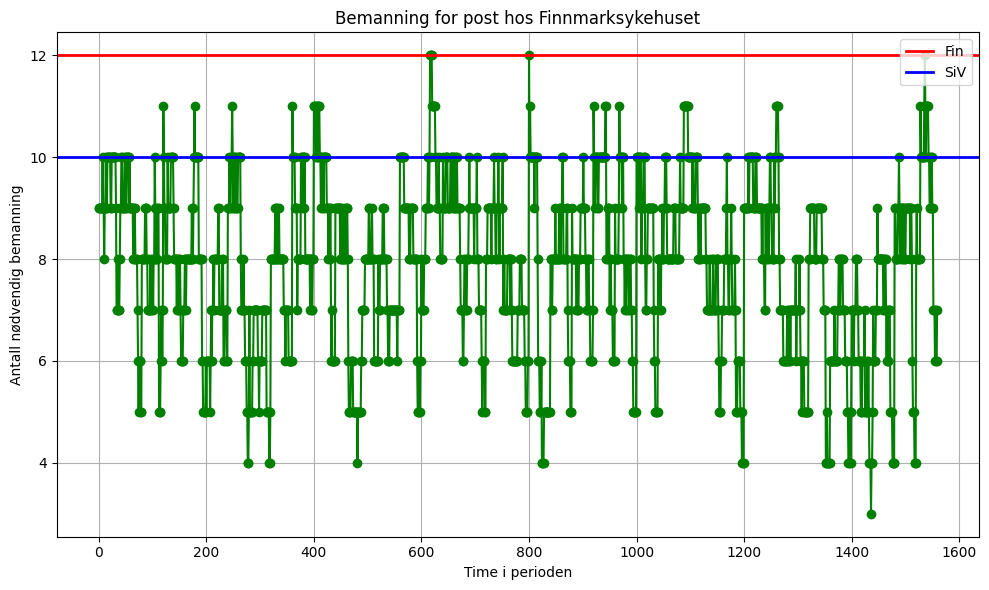

In [7]:
fin = 12
siv = 10
unn = 9

# staff_allocated = data_opt["staff_allocated"].tolist()
sim_avg_nurses = list(map(lambda x: 1 if x == 0 else x, sim_avg_nurses))
staff_opt_plot(sim_avg_nurses, fin, siv, unn, dag=True)

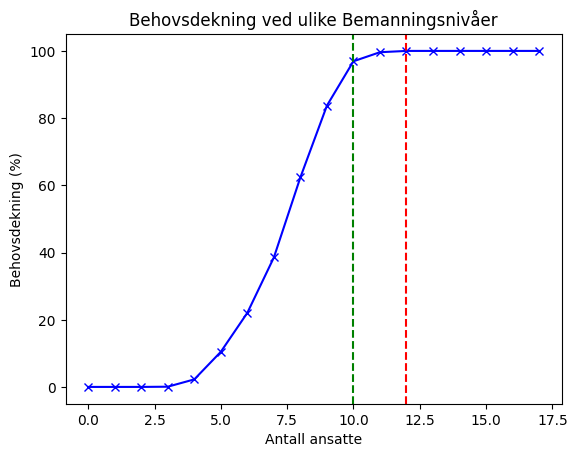

In [22]:
staff_level = behovsdekning_lineplot(12, sim_avg_nurses)

## Verifiseringsmodellen

0.8656632653061181

18.81377551020408

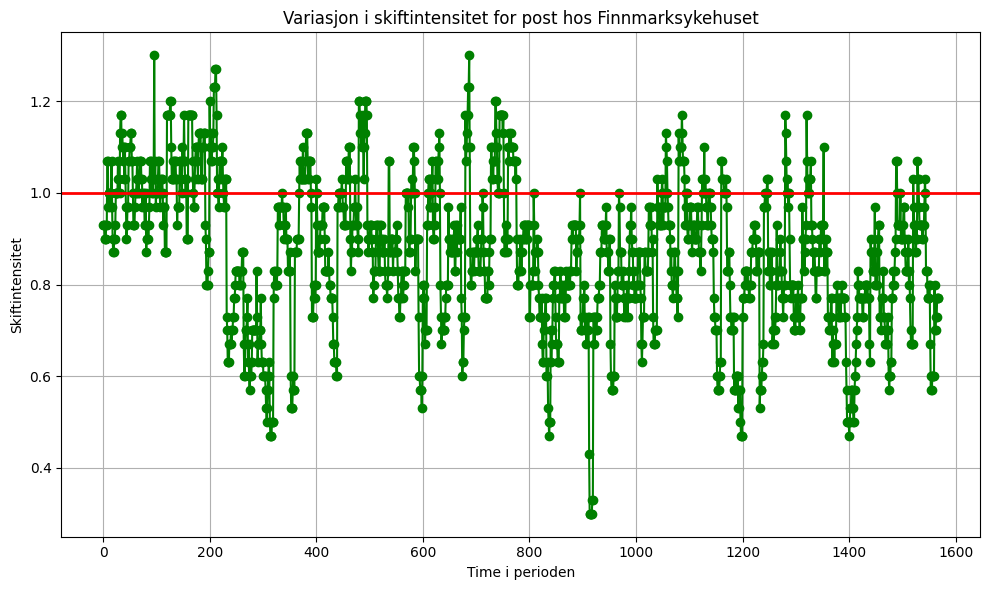

In [26]:
verifiseringsmodellen(fin_data_hourly=fin_data_hourly, PPP=3, staff_level=staff_level)

## Skiftmodellen

In [2]:
### optimeringsmodell for struktur av skiftene og hvor minimering av kostnad er objective function

## Turnusmodellen

In [ ]:
len(pd.date_range(start='2024-01-01 00:00', end='2024-02-28 23:00', freq='H'))
sim_avg_nurses = [i for i in range(1,1417)]

In [ ]:
# # Lage (foreløpig) dummydata for ansatte og stillingsprosenter

# # Ansatte
# employees = list(range(1, 41))

# # Stillingsprosenter
# values = [1.0] * 40 + [0.5] * 0 #+ [0.5] * 2 + [0.4] * 1
# np.random.shuffle(values)

# emp_pospct_df = pd.DataFrame({
#     'Ansatt': employees,
#     'Stillingsprosent': values
# })


# datetime_range = pd.date_range(start='2024-01-01 00:00', end='2024-02-28 23:00', freq='H')
# df = pd.DataFrame({'Datetime': datetime_range})
# df["År"] = df['Datetime'].dt.year
# df["Måned"] = df['Datetime'].dt.month_name()
# df["Dag"] = df["Datetime"].dt.day_name()
# df["Uke"] = df["Datetime"].dt.isocalendar().week
# df['helg'] = df['Datetime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
# df["Timer"] =df['Datetime'].dt.hour
# df["Timer"] = df["Timer"].astype(int)
# df["skift_type"] = df.apply(add_shift_type, axis=1)

# num_weeks = max(df["Uke"].tolist())
# emp_pospct_df['Weekend_Work'] = 3
# emp_pospct_df['7Day_Working_Hours'] = 40
# emp_pospct_df["Max_Work_Hours"] = emp_pospct_df["Stillingsprosent"] * 35 * num_weeks

# # sim_avg_nurses +=[5,4,3,6,5,4]*4
# df['demand'] = sim_avg_nurses
# df['dato'] = df['Datetime'].dt.date
# df['day_of_year'] = df['Datetime'].dt.dayofyear
# result = df.groupby(['dato',"Uke","day_of_year", 'Dag', 'skift_type'])['demand'].max().reset_index()

In [ ]:
result, num_weeks = create_df(sim_avg_nurses=sim_avg_nurses, function=add_shift_type)
emp_pospct_df = create_dummy_employee_data(num_emp=40, FTEs=40, num_part_time=0, num_weeks=num_weeks)
result['demand'] = result.apply(update_demand, axis=1)

In [ ]:
display(result)
display(emp_pospct_df)

In [ ]:
demand = result["demand"]
days = [0,1,2,3,4,5,6]
shifts = ['Dag', 'Kveld', 'Natt'] # , 'Fri'
employees = emp_pospct_df['Ansatt'].tolist()
position_percentage = emp_pospct_df['Stillingsprosent'].tolist()
weeks = list(set(result["Uke"].tolist()))
day_of_year = list(set(df['day_of_year'].tolist()))
shift_lengths = [8,8,8]
weekend_work = emp_pospct_df['Weekend_Work'].tolist()
weekly_hours = emp_pospct_df['7Day_Working_Hours'].tolist()
max_workinghours = emp_pospct_df["Max_Work_Hours"].tolist()

In [ ]:
result, status, obj, staff_allocation = opt_staffing_model(demand=demand, days=days, shifts=shifts,
                                                           employees=employees, position_percentage=position_percentage,
                                                           weeks=weeks, day_of_year = day_of_year, shift_lengths=shift_lengths, weekend_work=weekend_work,
                                                           weekly_hours=weekly_hours, max_workinghours=max_workinghours)

In [ ]:
for staff, allocation in staff_allocation.items():
    print(staff, allocation)

In [ ]:
import matplotlib.pyplot as plt

x = [0, 3, 6, 9, 12, 15] 
y = [23, 19, 16, 14, 13, 12] 

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='blue', label="Variasjon i Antall Årsverk")
plt.title("Årsverk ved variasjon i antall med 50% Stilling", fontsize=14)
plt.xlabel("Antall ansatte", fontsize=12)
plt.ylabel("Årsverk", fontsize=12)
plt.xticks(range(0, 16, 1))
plt.yticks(range(0, 25, 2))
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
employees = sorted(set(employee for employee, shift_type, day in staff_allocation.keys()))
shift_types = ["Natt", "Dag", "Kveld"]
days = sorted(set(day for employee, shift_type, day in staff_allocation.keys()))
index = pd.MultiIndex.from_product([days, shift_types], names=["Day", "Shift Type"])


df = pd.DataFrame(index=index, columns=employees)
for (employee, shift_type, day), value in staff_allocation.items():
    df.loc[(day, shift_type), employee] = value
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  

def color_cells(val):
    if pd.isna(val):
        val = 0
    return 'background-color: green' if val == 1 else 'background-color: red'

df = df.astype(int)
styled_df = df.style.applymap(color_cells)

# lagre html fil
styled_df.to_html("styled_work_schedule_30_emp_v5.html")
df.to_csv('finhf_workforce_schedule_v5.csv', index = False, encoding='utf-8')

## Kostnadsmodellen

In [3]:
### Kostnadsberegninger og modeller for kost, risiko etc. går her

## Ad-Hoc analyser

Gjennomsnittlig Antall pasienter ut av Post målt i Dag: 0.4125434027777778 pasienter pr Dag


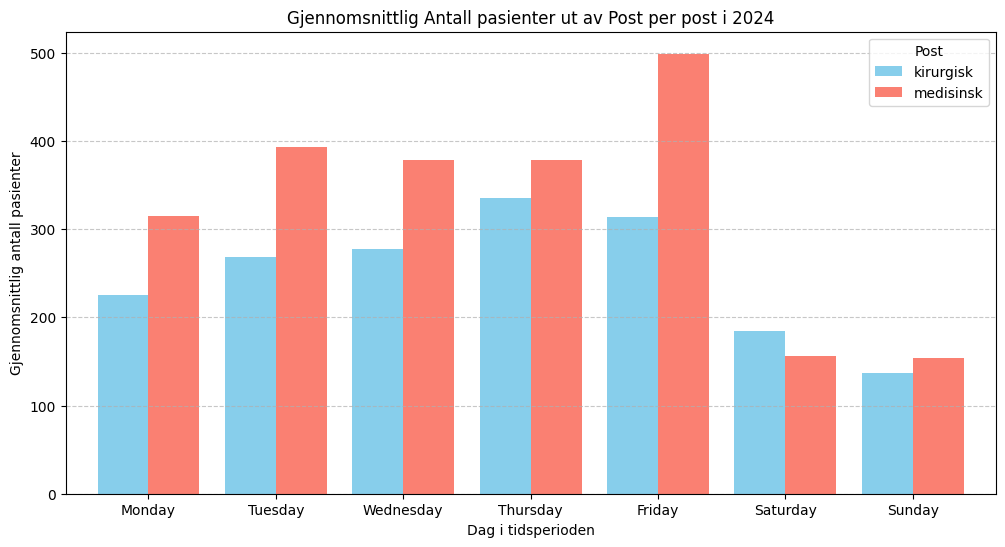

In [86]:
fin_data_hourly_24 = fin_data_hourly[(fin_data_hourly["År"] == 2024)] # & (fin_data_hourly["post"] == "kirurgisk") & (fin_data_hourly["helg"] == 1)
fin_data_hourly_24["Demand"] = fin_data_hourly_24["Antall inn på post"] + fin_data_hourly_24["Belegg"]
fin_data_hourly_24.loc[fin_data_hourly_24['skift_type'] == 'natt', 'Demand'] *= 0.33


avg = adhoc_plot(data=fin_data_hourly_24, tids_granulitetsniv="Dag", value="Antall pasienter ut av Post", skift_type="dag", aggregation_level="sum")

## Bemanningsverktøyet

In [2]:
fin_data_hourly = pd.read_csv('fin_data_hourly.csv')
fin_med_23 = fin_data_hourly[(fin_data_hourly["År"] == 2024) & (fin_data_hourly["post"] == "medisinsk")]
test = fin_med_23.loc[:, ["DatoTid","Uke", "Dag", "Timer", "Belegg", "skift_type"]]
excel_file = "test_data.xlsx"
df = pd.read_excel(excel_file, sheet_name= 'bemanningsplan (2)', engine='openpyxl')
df = df[df["Navn"] != "Inaktiv"]
ppp_df = pd.read_excel(excel_file, sheet_name= 'ppp', engine='openpyxl')
ppp_df = ppp_df[ppp_df["Navn"] == "Aktiv"]
døgnrytme_df = pd.read_excel(excel_file, sheet_name='døgnrytmetabell', engine='openpyxl')
display(df)
display(ppp_df.head())
display(døgnrytme_df.head())

,Start,End,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Week,Navn
28,07:30:00,15:15:00,9,9,9,9,9,0,0,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Grunnplan
29,12:00:00,20:00:00,2,2,2,2,2,0,0,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Grunnplan
30,15:00:00,22:30:00,9,9,9,9,7,0,0,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Grunnplan
31,22:15:00,07:30:00,4,4,4,4,0,0,0,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Grunnplan
32,08:00:00,20:15:00,0,0,0,0,0,8,8,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Grunnplan
33,20:00:00,08:15:00,0,0,0,0,4,5,5,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Grunnplan
34,07:30:00,15:15:00,4,4,4,4,4,4,4,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Alternativ 2
35,15:00:00,22:30:00,3,3,3,3,2,2,2,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Alternativ 2
36,22:15:00,07:30:00,2,2,2,2,2,2,2,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Alternativ 2
37,07:30:00,15:15:00,10,10,10,10,10,8,8,1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-1...,Alternativ 3


,Start,End,ppp_mon,ppp_tue,ppp_wed,ppp_thu,ppp_fri,ppp_sat,ppp_sun,Week,Navn


,Start,End,Aktivitet
0,00:00:00,01:00:00,3
1,01:00:00,02:00:00,3
2,02:00:00,03:00:00,2
3,03:00:00,04:00:00,2
4,04:00:00,05:00:00,1


In [5]:
df = df[df["Navn"] == 'Grunnplan']

In [6]:
import itertools
from datetime import time, timedelta


days_list = df.columns[2:-2].tolist()
week_num = []

for week in df.Week:
    week = str(week)
    for element in week.split("-"): 
        try:
            week_num.append(int(element))
        except:
            pass

dataset_weeks = list(range(min(week_num), max(week_num) + 1))
quarters = [time(hour, minute) for hour in range(24) for minute in (0, 15, 30, 45)]

kombinasjoner = list(itertools.product(dataset_weeks, days_list, quarters))
bemanningsplan = pd.DataFrame(kombinasjoner, columns=["Uke", "Dag", "Timer"])



In [7]:
bemanningsplan

,Uke,Dag,Timer
0,1,Monday,00:00:00
1,1,Monday,00:15:00
2,1,Monday,00:30:00
3,1,Monday,00:45:00
4,1,Monday,01:00:00
...,...,...,...
34939,52,Sunday,22:45:00
34940,52,Sunday,23:00:00
34941,52,Sunday,23:15:00
34942,52,Sunday,23:30:00


In [11]:
def match_and_add_activity(df, row):
    import numpy as np
    start_times = df['Start'].values
    end_times = df['End'].values
    timer = row["Timer"]

    matching_condition = (start_times <= timer) & (timer <= end_times)
    matching_rows = df[matching_condition]

    if not matching_rows.empty:
        return matching_rows.iloc[0]['Aktivitet']
    return None
    
bemanningsplan['DøgnrytmeAktivitet'] = bemanningsplan.apply(
    lambda row: match_and_add_activity(døgnrytme_df, row), axis=1
)


In [19]:

import pandas as pd
import numpy as np
from datetime import time

def oppdater_bemanningsplan(df, bemanningsplan, ppp_df):
    bemanningsplan["AntallAnsatte"] = 0
    bemanningsplan["PreDef_PPP"] = 0

    days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    for index, row in df.iterrows():
        start_time = row["Start"]
        end_time = row["End"]
        weeks = [int(w) for w in row["Week"].split("-")]

        for day_idx, day in enumerate(days_of_week):
            employees = row[day]
            if len(ppp_df) > 0:
                ppp = ppp_df.columns[2:-2][day_idx]
                ppp_level = ppp_df.loc[index, ppp]

            mask = (bemanningsplan["Dag"] == day) & (bemanningsplan["Uke"].isin(weeks))

            # Convert start_time and end_time to datetime for comparison
            start_datetime = pd.to_datetime(f"2000-01-01 {start_time}", format="%Y-%m-%d %H:%M:%S")
            end_datetime = pd.to_datetime(f"2000-01-01 {end_time}", format="%Y-%m-%d %H:%M:%S")

            if start_datetime <= end_datetime:
                # When the shift is within the same day
                mask = mask & (bemanningsplan["Timer"].between(start_datetime.time(), (end_datetime - pd.Timedelta(seconds=1)).time()))
            else:
                # For shifts that go over midnight
                mask1 = mask & (bemanningsplan["Timer"].between(start_datetime.time(), time(23, 59, 59)))
                mask2 = mask & (bemanningsplan["Timer"].between(time(0, 0), end_datetime.time()))
                mask = mask1 | mask2

            bemanningsplan.loc[mask, "AntallAnsatte"] += employees
            if len(ppp_df) > 0:
                bemanningsplan.loc[mask, "PreDef_PPP"] += ppp_level

    return bemanningsplan


oppdatert_bemanningsplan = oppdater_bemanningsplan(df, bemanningsplan, ppp_df)

In [20]:
print(oppdatert_bemanningsplan[(oppdatert_bemanningsplan["Uke"] == 1) & (oppdatert_bemanningsplan["Dag"] == "Monday")].to_string())

    Uke     Dag     Timer  DøgnrytmeAktivitet  AntallAnsatte  PreDef_PPP
0     1  Monday  00:00:00                   3              4           0
1     1  Monday  00:15:00                   3              4           0
2     1  Monday  00:30:00                   3              4           0
3     1  Monday  00:45:00                   3              4           0
4     1  Monday  01:00:00                   3              4           0
5     1  Monday  01:15:00                   3              4           0
6     1  Monday  01:30:00                   3              4           0
7     1  Monday  01:45:00                   3              4           0
8     1  Monday  02:00:00                   3              4           0
9     1  Monday  02:15:00                   2              4           0
10    1  Monday  02:30:00                   2              4           0
11    1  Monday  02:45:00                   2              4           0
12    1  Monday  03:00:00                   2      

In [69]:
def oppdater_bemanningsplan(df, bemanningsplan, ppp_df):
    from datetime import time
    bemanningsplaner = df.Navn.unique().tolist()
    for plan in bemanningsplaner:
        bemanningsplan[f"{plan}_AntallAnsatte"] = 0
        bemanningsplan[f"{plan}_PreDef_PPP"] = 0
        df_test = df[df["Navn"] == plan]
        for _, row in df_test.iterrows():
            start_time = row["Start"]
            end_time = row["End"]
            weeks = [int(w) for w in row["Week"].split("-")]

            for day_idx, day in enumerate(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]):
                employees = row[day]
                if len(ppp_df) > 0:
                    ppp = ppp_df.columns[2:-2][day_idx]
                    ppp_level = ppp_df.loc[_, ppp]
                for week in weeks:
                    if start_time <= end_time:  # Vanlig skift innenfor samme dag
                        mask = (
                            (bemanningsplan["Uke"] == week) &
                            (bemanningsplan["Dag"] == day) &
                            (bemanningsplan["Timer"] >= start_time) &
                            (bemanningsplan["Timer"] < end_time)
                        )
                        bemanningsplan.loc[mask, f"{plan}_AntallAnsatte"] += employees
                        if len(ppp_df) > 0:
                            bemanningsplan.loc[mask, f"{plan}_PreDef_PPP"] += ppp_level

                    else:  # Skift som går over til neste dag
                        mask_day1 = (
                            (bemanningsplan["Uke"] == week) &
                            (bemanningsplan["Dag"] == day) &
                            (bemanningsplan["Timer"] >= start_time) &
                            (bemanningsplan["Timer"] < time(23,59, 59))
                        )
                        bemanningsplan.loc[mask_day1, f"{plan}_AntallAnsatte"] += employees
                        if len(ppp_df) > 0:
                            bemanningsplan.loc[mask_day1, f"{plan}_PreDef_PPP"] += ppp_level

                        # Timer fra midnatt til neste skift
                        next_day_idx = (day_idx + 1) % 7  
                        next_day = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][next_day_idx]
                        mask_day2 = (
                            (bemanningsplan["Uke"] == week) &
                            (bemanningsplan["Dag"] == next_day) &
                            (bemanningsplan["Timer"] >= time(0,0)) &
                            (bemanningsplan["Timer"] < end_time)
                        )
                        bemanningsplan.loc[mask_day2, f"{plan}_AntallAnsatte"] += employees
                        if len(ppp_df) > 0:
                            bemanningsplan.loc[mask_day2, f"{plan}_PreDef_PPP"] += ppp_level

    return bemanningsplan

oppdatert_bemanningsplan = oppdater_bemanningsplan(df, bemanningsplan, ppp_df)


In [13]:
test = test[test.Uke.isin(dataset_weeks)]

test['DatoTid'] = pd.to_datetime(test['DatoTid'])

def create_quarterly_times_and_update_timer(row):
    times = []
    timer_values = []
    for minute in [0, 15, 30, 45]:
        new_time = row['DatoTid'].replace(minute=minute, second=0)
        times.append(new_time)
        timer_values.append(new_time.time())
    return list(zip(times, timer_values))

new_rows = []
for _, row in test.iterrows():
    quarterly_times_and_timers = create_quarterly_times_and_update_timer(row)
    for time, timer in quarterly_times_and_timers:
        new_row = row.copy()
        new_row['DatoTid'] = time
        new_row['Timer'] = timer
        new_rows.append(new_row)

df_quarterly = pd.DataFrame(new_rows)

In [10]:
df_quarterly

,DatoTid,Uke,Dag,Timer,Belegg,skift_type
69726,2024-01-01 00:00:00,1,Monday,00:00:00,24.0,natt
69726,2024-01-01 00:15:00,1,Monday,00:15:00,24.0,natt
69726,2024-01-01 00:30:00,1,Monday,00:30:00,24.0,natt
69726,2024-01-01 00:45:00,1,Monday,00:45:00,24.0,natt
69728,2024-01-01 01:00:00,1,Monday,01:00:00,24.0,natt
...,...,...,...,...,...,...
85419,2024-12-31 22:45:00,1,Tuesday,22:45:00,20.0,kveld
85420,2024-12-31 23:00:00,1,Tuesday,23:00:00,21.0,natt
85420,2024-12-31 23:15:00,1,Tuesday,23:15:00,21.0,natt
85420,2024-12-31 23:30:00,1,Tuesday,23:30:00,21.0,natt


In [14]:
def add_shift_type_quarterly(row):
    from datetime import datetime
    morning_start = datetime.strptime("07:15:00", "%H:%M:%S").time()
    afternoon_start = datetime.strptime("14:45:00", "%H:%M:%S").time()
    evening_start = datetime.strptime("21:45:00", "%H:%M:%S").time()
    
    row_time = row["Timer"]

    # Sammenligning
    if morning_start < row_time <= afternoon_start:
        shift_type = "dag"
    elif afternoon_start < row_time <= evening_start:
        shift_type = "kveld"
    else: 
        shift_type = "natt"
        
    return shift_type

df_quarterly["skift_type"] = df_quarterly.apply(add_shift_type_quarterly, axis=1)

In [15]:
kombinert_tabell = df_quarterly.merge(bemanningsplan, on=["Uke", "Dag", "Timer"], how="left")
kombinert_tabell

,DatoTid,Uke,Dag,Timer,Belegg,skift_type,DøgnrytmeAktivitet
0,2024-01-01 00:00:00,1,Monday,00:00:00,24.0,natt,3
1,2024-01-01 00:15:00,1,Monday,00:15:00,24.0,natt,3
2,2024-01-01 00:30:00,1,Monday,00:30:00,24.0,natt,3
3,2024-01-01 00:45:00,1,Monday,00:45:00,24.0,natt,3
4,2024-01-01 01:00:00,1,Monday,01:00:00,24.0,natt,3
...,...,...,...,...,...,...,...
35131,2024-12-31 22:45:00,1,Tuesday,22:45:00,20.0,natt,6
35132,2024-12-31 23:00:00,1,Tuesday,23:00:00,21.0,natt,6
35133,2024-12-31 23:15:00,1,Tuesday,23:15:00,21.0,natt,4
35134,2024-12-31 23:30:00,1,Tuesday,23:30:00,21.0,natt,4


In [23]:
kombinert_tabell = df_quarterly.merge(oppdatert_bemanningsplan, on=["Uke", "Dag", "Timer"], how="left")
kombinert_tabell.head(10)

,DatoTid,Uke,Dag,Timer,Belegg,skift_type,DøgnrytmeAktivitet,AntallAnsatte,PreDef_PPP
0,2024-01-01 00:00:00,1,Monday,00:00:00,24.0,natt,3,4,0
1,2024-01-01 00:15:00,1,Monday,00:15:00,24.0,natt,3,4,0
2,2024-01-01 00:30:00,1,Monday,00:30:00,24.0,natt,3,4,0
3,2024-01-01 00:45:00,1,Monday,00:45:00,24.0,natt,3,4,0
4,2024-01-01 01:00:00,1,Monday,01:00:00,24.0,natt,3,4,0
5,2024-01-01 01:15:00,1,Monday,01:15:00,24.0,natt,3,4,0
6,2024-01-01 01:30:00,1,Monday,01:30:00,24.0,natt,3,4,0
7,2024-01-01 01:45:00,1,Monday,01:45:00,24.0,natt,3,4,0
8,2024-01-01 02:00:00,1,Monday,02:00:00,24.0,natt,3,4,0
9,2024-01-01 02:15:00,1,Monday,02:15:00,24.0,natt,2,4,0


### Pasientstrøm gjennom året

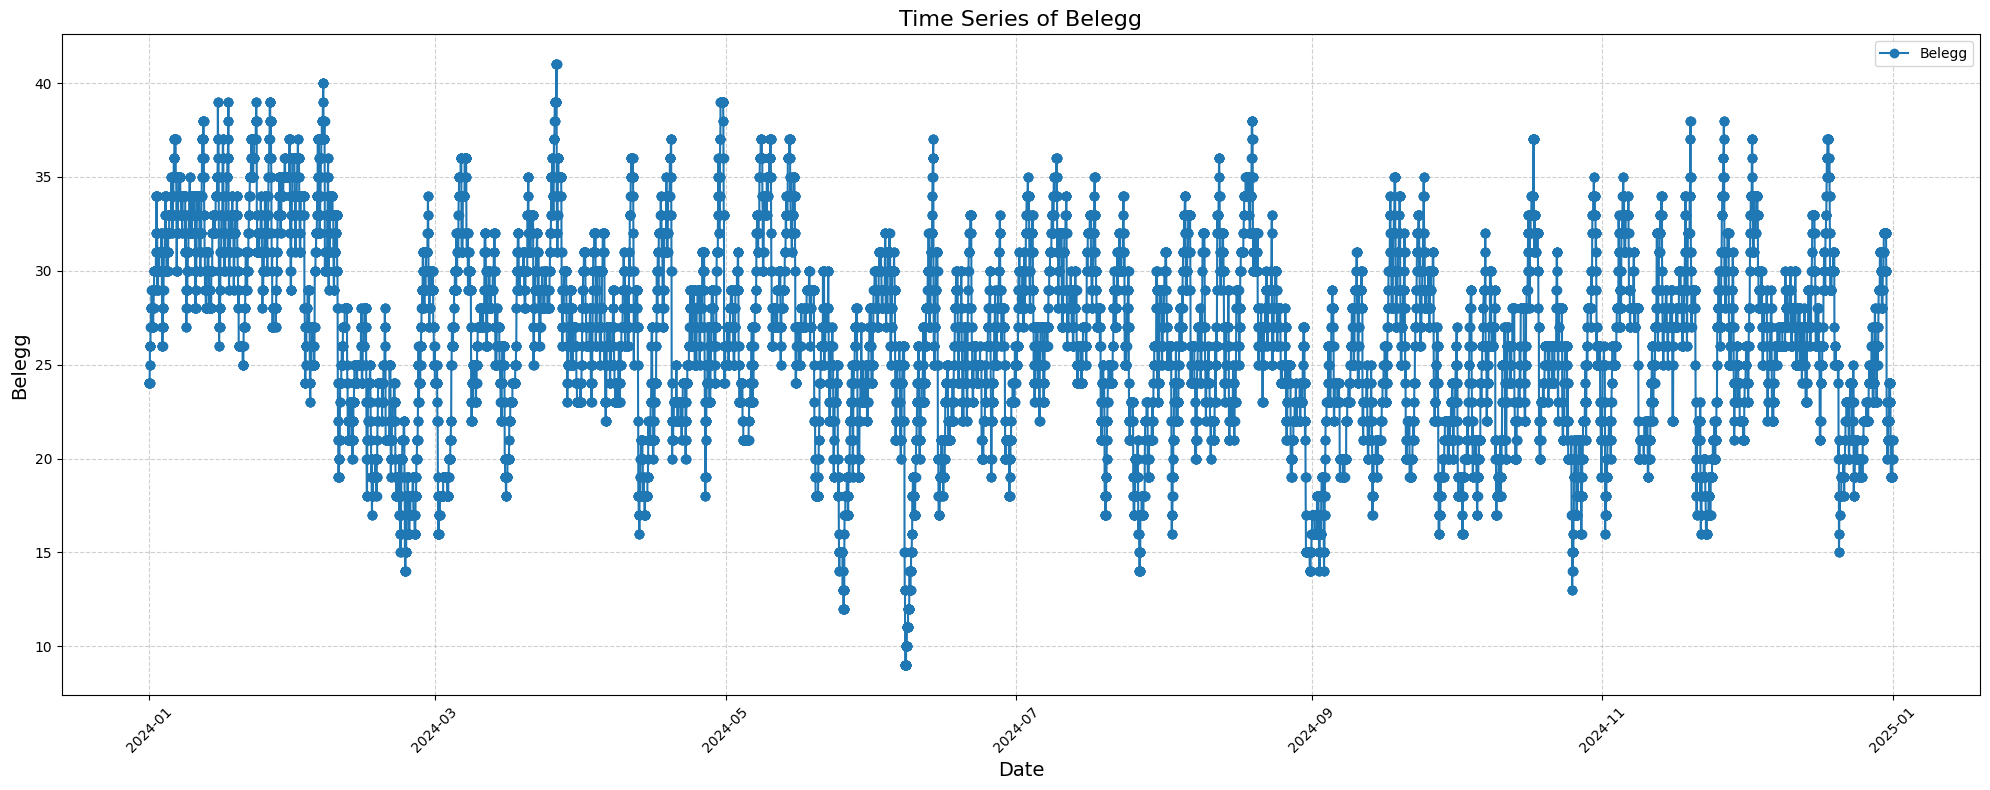

In [68]:
kombinert_tabell["DatoTid"] = pd.to_datetime(kombinert_tabell["DatoTid"])

plt.figure(figsize=(20, 8)) 
plt.plot(kombinert_tabell["DatoTid"], kombinert_tabell["Belegg"], marker="o", label="Belegg")
plt.title("Time Series of Belegg", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Belegg", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)  
plt.legend()  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### SkiftIntensitet

In [16]:
def nightshift_weight(row: pd.Series) -> pd.Series:
    import math
    row["Belegg"] = int(math.ceil(row["Belegg"]*(row["DøgnrytmeAktivitet"]/10)))
    # if row["skift_type"] == "natt":
    #     row["Belegg"] = int(math.ceil(row["Belegg"]*0.25))
    return row

def PPP(row: pd.Series) -> int:
    import math
    ppp = round(row['Belegg']/row["AntallAnsatte"], 2)
    return ppp

In [ ]:
import math
kombinert_tabell = kombinert_tabell.apply(nightshift_weight, axis=1)
kombinert_tabell['Reell_PPP'] = kombinert_tabell.apply(PPP, axis=1)
kombinert_tabell.head()

,DatoTid,Uke,Dag,Timer,Belegg,skift_type,DøgnrytmeAktivitet
0,2024-01-01 00:00:00,1,Monday,00:00:00,8,natt,3
1,2024-01-01 00:15:00,1,Monday,00:15:00,8,natt,3
2,2024-01-01 00:30:00,1,Monday,00:30:00,8,natt,3
3,2024-01-01 00:45:00,1,Monday,00:45:00,8,natt,3
4,2024-01-01 01:00:00,1,Monday,01:00:00,8,natt,3


In [14]:
def SkiftIntensitet(row: pd.Series) -> int:
    try:
        SI = row['Belegg']/ (row["AntallAnsatte"]*row["PreDef_PPP"])
    except ZeroDivisionError:
        SI = 0
    return SI
kombinert_tabell['SI'] = kombinert_tabell.apply(SkiftIntensitet, axis=1)

In [15]:
kombinert_tabell.head()

,DatoTid,Uke,Dag,Timer,Belegg,skift_type,DøgnrytmeAktivitet,AntallAnsatte,PreDef_PPP,Reell_PPP,SI
0,2024-01-01 00:00:00,1,Monday,00:00:00,8,natt,3,4,0,2.0,0
1,2024-01-01 00:15:00,1,Monday,00:15:00,8,natt,3,4,0,2.0,0
2,2024-01-01 00:30:00,1,Monday,00:30:00,8,natt,3,4,0,2.0,0
3,2024-01-01 00:45:00,1,Monday,00:45:00,8,natt,3,4,0,2.0,0
4,2024-01-01 01:00:00,1,Monday,01:00:00,8,natt,3,4,0,2.0,0


In [22]:
def bemanningsverktoy(df, tidsperiode, skift, aggregering, visualiseringskolonne):
    kombinert_tabell = df
    if tidsperiode == "hele perioden":
        kombinert_tabell = kombinert_tabell
    else:
        tidsperiode = pd.to_datetime(tidsperiode)
        start, end = tidsperiode
        kombinert_tabell = kombinert_tabell[(kombinert_tabell["DatoTid"] >= start) & (kombinert_tabell["DatoTid"] <= end)] 
    
    
    if skift != "alle skift":
        skifttype = skift
        kombinert_tabell = kombinert_tabell[kombinert_tabell["skift_type"] == skifttype]   
    else:
        kombinert_tabell = kombinert_tabell
    
    # ukesnivå
    if aggregering == "gjennomsnittlig uke":
        # Average week
        tabell = kombinert_tabell.groupby(["Dag", "Timer"])[visualiseringskolonne].mean().reset_index()
        # result = result.pivot(index="Timer", columns="Dag", values=visualiseringskolonne)
    elif aggregering == "beste uke":
        result = kombinert_tabell.groupby("Uke")[visualiseringskolonne].mean().idxmin()
        tabell = kombinert_tabell[kombinert_tabell["Uke"] == result]
    elif aggregering == "dårligste uke":
        result = kombinert_tabell.groupby("Uke")[visualiseringskolonne].mean().idxmax()
        tabell = kombinert_tabell[kombinert_tabell["Uke"] == result]
    
    # Dagsnivå
    elif aggregering == "gjennomsnittlig dag":
        tabell = kombinert_tabell.groupby("Timer")[visualiseringskolonne].mean().reset_index()
    elif aggregering == "beste dag":
        result = kombinert_tabell.groupby(["Uke","Dag"])[visualiseringskolonne].mean().idxmin()
        tabell = kombinert_tabell[kombinert_tabell[["Uke", "Dag"]].apply(tuple, axis=1) == result]
        if len(tabell) < 80:
            result = kombinert_tabell.groupby(["Uke","Dag"])[visualiseringskolonne].mean().nsmallest(2).idxmax()
            tabell = kombinert_tabell[kombinert_tabell[["Uke", "Dag"]].apply(tuple, axis=1) == result]
    elif aggregering == "dårligste dag":
        result = kombinert_tabell.groupby(["Uke","Dag"])[visualiseringskolonne].mean().idxmax()
        tabell = kombinert_tabell[kombinert_tabell[["Uke", "Dag"]].apply(tuple, axis=1) == result]  
        
    # skift nivå
    elif aggregering == "gjennomsnittlig skift":
        tabell = kombinert_tabell.groupby("skift_type")[visualiseringskolonne].mean().reset_index()
    try:
        if aggregering == "beste skift":
            result = kombinert_tabell.groupby(["Uke","Dag"])[visualiseringskolonne].mean().idxmin()
            tabell = kombinert_tabell[kombinert_tabell[["Uke", "Dag"]].apply(tuple, axis=1) == result]
            if len(tabell) < 15:
                result = kombinert_tabell.groupby(["Uke","Dag"])[visualiseringskolonne].mean().nsmallest(2).idxmax()
                tabell = kombinert_tabell[kombinert_tabell[["Uke", "Dag"]].apply(tuple, axis=1) == result]
        elif aggregering == "dårligste skift":
            result = kombinert_tabell.groupby(["Uke","Dag"])[visualiseringskolonne].mean().idxmax()
            tabell = kombinert_tabell[kombinert_tabell[["Uke", "Dag"]].apply(tuple, axis=1) == result]
    except:
        tabell = None
    
    
    if aggregering == "hele perioden":
        visualisering = kombinert_tabell[visualiseringskolonne].tolist()
        plt.figure(figsize=(20, 8))
        # plt.plot(kombinert_tabell["DatoTid"],needed_nurses_intensity_rounded, marker='o', color='g', linestyle='-')
        plt.plot(kombinert_tabell["DatoTid"],visualisering, marker='o', color='g', linestyle='-')
        plt.title(f'Variasjon i {visualiseringskolonne} for post hos Finnmarksykehuset gjennom tidsperiode')
        # plt.axhline(y=1.0, color="r", linewidth = 2, linestyle = "-")
        plt.xlabel('Tidsperiode')
        plt.ylabel(f'{visualiseringskolonne} (i desimal)')
        plt.grid(True)
        plt.xticks(kombinert_tabell['DatoTid'].dt.date.unique().tolist(), rotation=45)
        plt.tight_layout()
        plt.show()

    else:
        try:
            df = tabell
            # Konverter Timer til datetime.time og deretter til minutter siden midnatt
            df["Timer"] = pd.to_datetime(df["Timer"], format="%H:%M:%S").dt.time
            df["Minutes"] = df["Timer"].apply(lambda t: t.hour * 60 + t.minute)

            # Lag plottet
            plt.figure(figsize=(12, 6))

            if aggregering in ["gjennomsnittlig uke", "beste uke", "dårligste uke"]:
                # Plot en linje for hver dag
                for dag in df["Dag"].unique():
                    subset = df[df["Dag"] == dag]
                    plt.plot(subset["Minutes"], subset[visualiseringskolonne], marker="o", label=dag)

            else:
                plt.plot(df["Minutes"], df[visualiseringskolonne], marker="o")

            # Tilpass aksene
            plt.xlabel("Tid", fontsize=12)
            plt.ylabel(visualiseringskolonne, fontsize=12)
            plt.title(f"{visualiseringskolonne} for {aggregering} over {tidsperiode}", fontsize=14)
            plt.xticks(
                ticks=[i * 60 for i in range(24)],
                labels=[f"{i:02d}:00" for i in range(24)],  # Viser timer fra 00:00 til 23:00
                rotation=45,
                fontsize=10,
            )
            if aggregering in ["gjennomsnittlig uke", "beste uke", "dårligste uke"]:
                plt.legend(title="Dag", fontsize=10)
                
            plt.grid(True, linestyle="--", alpha=0.7)

            # Vis plottet
            plt.tight_layout()
            plt.show()
        except:
            return df
    return df

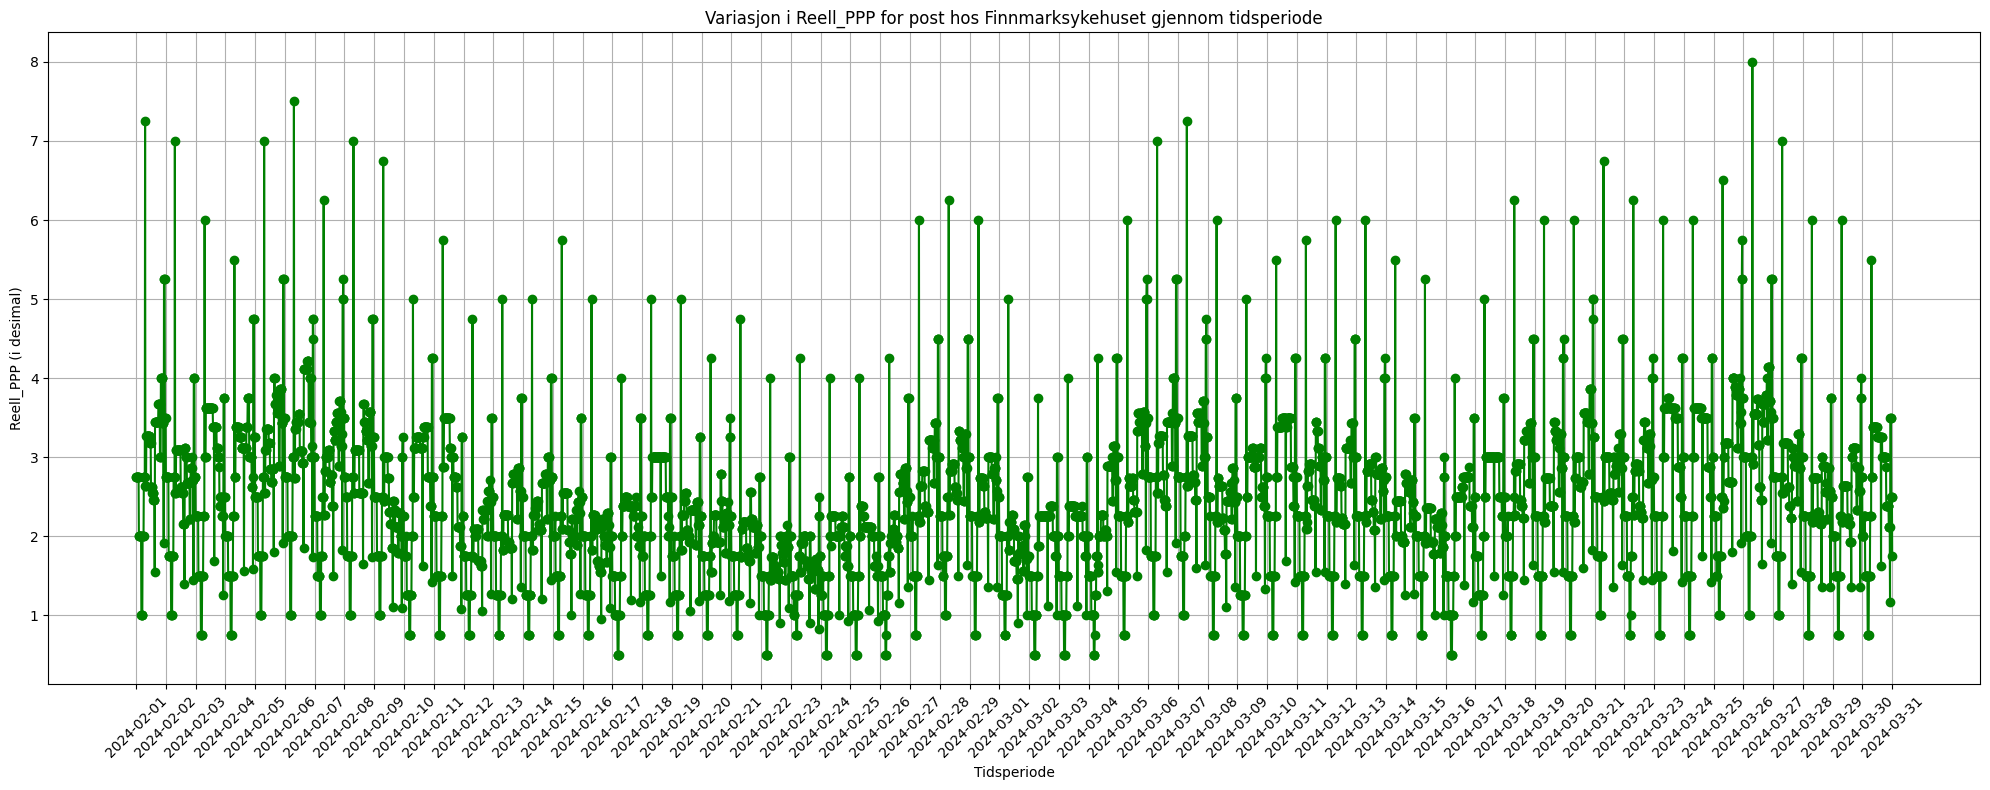

In [27]:
tidsperiode = ["02/01/2024", "03/31/2024"]
# tidsperiode = "hele perioden"
aggregering = "hele perioden"
visualiseringskolonne = "Reell_PPP"
skift = "alle skift"
df = kombinert_tabell

df = bemanningsverktoy(df = df, tidsperiode = tidsperiode, skift = skift, aggregering = aggregering, visualiseringskolonne = visualiseringskolonne)

In [ ]:
# def bemanningsverktoy_gammel(kombinert_tabell: pd.DataFrame, visualiseringskolonne: str):
    
#     visualisering = kombinert_tabell[visualiseringskolonne].tolist()
#     # needed_nurses_intensity_rounded = kombinert_tabell["SI"].tolist()
#     # PPP_reell = kombinert_tabell["Reell_PPP"].tolist()
#     # PPP_predef = kombinert_tabell["PreDef_PPP"].tolist()

#     if visualiseringskolonne == "SI":
#         avg = sum(visualisering)/len(visualisering)
#         over = []
#         correct = []
#         for i in visualisering:
#             if i > 1:        
#                 over.append(i)
#             else:
#                 correct.append(i)

#         pct_over = len(over)/len(visualisering)*100
#         print(avg)
#         print(pct_over)


#     plt.figure(figsize=(20, 8))
#     # plt.plot(kombinert_tabell["DatoTid"],needed_nurses_intensity_rounded, marker='o', color='g', linestyle='-')
#     plt.plot(kombinert_tabell["DatoTid"],visualisering, marker='o', color='g', linestyle='-')
#     plt.title(f'Variasjon i {visualiseringskolonne} for post hos Finnmarksykehuset gjennom tidsperiode')
#     # plt.axhline(y=1.0, color="r", linewidth = 2, linestyle = "-")
#     plt.xlabel('Tidsperiode')
#     plt.ylabel(f'{visualiseringskolonne} (i desimal)')
#     plt.grid(True)
#     plt.xticks(kombinert_tabell['DatoTid'].dt.date.unique().tolist(), rotation=45)
#     plt.tight_layout()
#     plt.show()

# bemanningsverktoy_gammel(kombinert_tabell=kombinert_tabell, visualiseringskolonne="SI")